In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import statsmodels.api as sm
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

/home/harshit/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [46]:
path = "/home/harshit/Project/Returns/averages/"
factors = pd.read_csv(path+"FourFactors.csv")

In [47]:
#Making single dataframe having entropy factor values for all years
ent_ret1 = pd.read_csv(path+"average2013.csv").drop([0])
ent_ret1.Date = ent_ret1.Date.apply(lambda x: x.replace("-",""))
ent_ret2 = pd.read_csv(path+"average2014.csv").drop([0])
ent_ret2.Date = ent_ret2.Date.apply(lambda x: x.replace("-",""))
ent_ret3 = pd.read_csv(path+"average2015.csv").drop([0])
ent_ret3.Date = ent_ret3.Date.apply(lambda x: x.replace("-",""))
ent_ret4 = pd.read_csv(path+"average2016.csv").drop([0])
ent_ret4.Date = ent_ret4.Date.apply(lambda x: x.replace("-",""))
ent_ret5 = pd.read_csv(path+"average2017.csv").drop([0])
ent_ret5.Date = ent_ret5.Date.apply(lambda x: x.replace("-",""))

In [48]:
#Making single dataframe having values for all years FOR RENYI_ENTROPY
ren_ent_ret1 = pd.read_csv(path+"renyi_average2013.csv").drop([0])
ren_ent_ret1.Date = ent_ret1.Date.apply(lambda x: x.replace("-",""))
ren_ent_ret2 = pd.read_csv(path+"renyi_average2014.csv").drop([0])
ren_ent_ret2.Date = ent_ret2.Date.apply(lambda x: x.replace("-",""))
ren_ent_ret3 = pd.read_csv(path+"renyi_average2015.csv").drop([0])
ren_ent_ret3.Date = ent_ret3.Date.apply(lambda x: x.replace("-",""))
ren_ent_ret4 = pd.read_csv(path+"renyi_average2016.csv").drop([0])
ren_ent_ret4.Date = ent_ret4.Date.apply(lambda x: x.replace("-",""))
ren_ent_ret5 = pd.read_csv(path+"renyi_average2017.csv").drop([0])
ren_ent_ret5.Date = ent_ret5.Date.apply(lambda x: x.replace("-",""))

In [49]:
entire = pd.concat([ent_ret1,ent_ret2,ent_ret3,ent_ret4,ent_ret5],ignore_index=True)
entire["Date"] = entire["Date"].apply(pd.to_numeric) # converting datatype of dates to numeric

#FOR RENYI_ENTROPY
ren_entire = pd.concat([ren_ent_ret1,ren_ent_ret2,ren_ent_ret3,ren_ent_ret4,ren_ent_ret5],ignore_index=True)
ren_entire["Date"] = entire["Date"].apply(pd.to_numeric) # converting datatype of dates to numeric

In [89]:
#joining frames to have a single dataframe having all the factors together
all_factors= pd.merge(factors,entire,on="Date") # Joining dataframe of factors and entropyfactor
#all_factors.to_csv("/home/harshit/Project/allfactors.csv",index=False)

# for reney entropy
ren_all_factors= pd.merge(factors,ren_entire,on="Date")
#ren_all_factors.to_csv("/home/harshit/Project/allfactors.csv",index=False)

In [ ]:
#Making company vise csv's of returns for all years
eq_path = "/home/harshit/Project/all_price_by_company/"
eq_list = os.listdir("/home/harshit/Project/all_price_by_company/")
eq_list = pd.DataFrame(eq_list,columns=["Equities"])
return_path = "/home/harshit/Project/risk_free_ret/all_ret_by_company/"
for i in eq_list["Equities"]:
    df2 = pd.DataFrame(columns=["Date","Return"])
    name = i.split('.')[0]
    data = pd.read_csv(eq_path+i)
    for j in range(len(data)):
        date = data.iloc[j]["Date"]
        previous = data.iloc[j-1][name]
        new = data.iloc[j][name]
        ret = ((previous-new)/previous)*100
        df = pd.DataFrame([[date,ret]],columns=["Date","Return"])
        df2 = df2.append(df,ignore_index=True)      # A DF having return data for all dates
        df2.at[0, 'Return'] = 0
        df2.to_csv(return_path+i,index=False)

In [93]:
#Applying Linear Regression to equities
eq_path = "/home/harshit/Project/risk_free_ret/all_ret_by_company/"
model_car_path = "/home/harshit/Project/car_models/"  # PATH FOR CARHART MODELS
model3_path = "/home/harshit/Project/complete_models/" # PATH FOR MODELS WITH ALL FACTORS USED
eq_list = os.listdir(eq_path) #a list of all equities
eq_list = pd.DataFrame(eq_list,columns=["Equities"])

r2score = pd.DataFrame(columns=["Symbol","ent","car"])
pvals   = pd.DataFrame(columns=["Symbol","SMB %","HML %","WML %","Rm-Rf %","high-low","F-statistics","P(F-value)","Adj-r_sq"])
for i in eq_list["Equities"]:   #making model for each company over the entire period
    equity = pd.read_csv(eq_path+i)
    equity=equity.drop([0])
    all_data = pd.merge(all_factors,equity,on="Date") # Making a dataframe by date,having all factors and equity returns
    ren_all_data = pd.merge(ren_all_factors,equity,on="Date") # FOR RENYI_ENTROPY
    symbol = i.split('.')[0]  #Removing ".csv" to get file name
    all_data.rename(columns={'Return':symbol}, inplace=True)
   
    X1= all_data[["SMB %","HML %","WML %","Rm-Rf %","high-low"]] #Making X variable for entropy included model
    X1 = sm.add_constant(X1)
    X2= all_data[["SMB %","HML %","WML %","Rm-Rf %"]] #Making X variable for Carhart 4 factor model
    X2 = sm.add_constant(X2)
    y = all_data[[symbol]]
 
    #Making model without entropy
    model2= sm.OLS(y,X2,hasconst=True).fit()   #model for carhart 4 factor
    model2_name = model_car_path+symbol+".sav"
    
    #making a model without test-train divide
    model3 = sm.OLS(y,X1,hasconst=True).fit()
    model3_name = model3_path+symbol+".sav"
    
    pickle.dump(model2,open(model2_name,"wb"))
    pickle.dump(model3,open(model3_name,"wb"))
    #comparing model 1 and 2 by saving r2 scores
    ent = r2_score(y,model3.predict(X1))*100 
    car = r2_score(y,model2.predict(X2))*100
    df = pd.DataFrame([[symbol,ent,car]],
                      columns=["Symbol","ent","car"])
    r2score= r2score.append(df,ignore_index=True)
    #saving model statistics and pvalues of variables
    a=pd.DataFrame(model3.pvalues).T
    a.insert(0,"Symbol",symbol)
    a.insert(6,"F-statistics",model3.fvalue)
    a.insert(7,"P(F-value)",model3.f_pvalue)
    a.insert(8,"Adj-r_sq",model3.rsquared_adj)
    pvals=pvals.append(a,ignore_index=True)
    pvals=pvals.round(4)                     #round() removes scientific notation

r2score.to_csv("/home/harshit/Project/r2scores.csv")
pvals.to_csv("/home/harshit/Project/pvalues.csv")

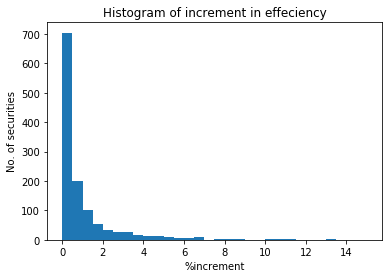

2

In [43]:
x=pd.DataFrame((r2score["ent"]-r2score["car"])*100/r2score["car"],columns=["increment"])
std = x["increment"].std()
#x = x[(x["increment"])<2*std]
# the histogram of the data
n, bins, patches = plt.hist(x["increment"],30,range=(0,15))
plt.xlabel('%increment')
plt.ylabel('No. of securities')
plt.title('Histogram of increment in effeciency')
plt.show()
len(x[x["increment"]>55.77])

In [247]:
x=pd.DataFrame((r2score["ent"]-r2score["car"])*100/r2score["car"],columns=["increment"])
len(x[x['increment']>60])

1

In [2]:
#Applying Linear Regression using multiple set of independents for entire period
eq_path = "/home/harshit/Project/risk_free_ret/all_ret_by_company/"
model_car_path = "/home/harshit/Project/car_models/" 
model_ent_path = "/home/harshit/Project/ent_models/"
eq_list = os.listdir("/home/harshit/Project/risk_free_ret/all_ret_by_company/") #a list of all equities
eq_list = pd.DataFrame(eq_list,columns=["Equities"])

pvals_rm_rf   = pd.DataFrame(columns=["Symbol","Rm-Rf %","Adj-r_sq"])
pvals_rm_smb   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","Adj-r_sq"])
pvals_rm_smb_hml   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","HML %","Adj-r_sq"])
for i in eq_list["Equities"]:   #making model for each company over the entire period
    equity = pd.read_csv(eq_path+i)
    equity=equity.drop([0])
    all_data = pd.merge(all_factors,equity,on="Date") # Making a dataframe by date,having all factors and equity returns
    symbol = i.split('.')[0]  #Removing ".csv" to get file name
    all_data.rename(columns={'Return':symbol}, inplace=True)
    X1= all_data[["Rm-Rf %"]] #Making X variable for entropy included model
    X1 = sm.add_constant(X1)
    X2= all_data[["Rm-Rf %","high-low"]]
    X2= sm.add_constant(X2)
    X3=all_data[["Rm-Rf %","SMB %","HML %"]]
    X3= sm.add_constant(X3)
 
    y = all_data[[symbol]]
    model1 = sm.OLS(y,X1,hasconst=True).fit()
    model2 = sm.OLS(y,X2,hasconst=True).fit()
    model3 = sm.OLS(y,X3,hasconst=True).fit()
   
    a=pd.DataFrame(model1.pvalues).T
    a2=pd.DataFrame(model2.pvalues).T
    a3=pd.DataFrame(model3.pvalues).T
  
    a.insert(0,"Symbol",symbol)
    a2.insert(0,"Symbol",symbol)
    a3.insert(0,"Symbol",symbol)
    
    a.insert(2,"Adj-r_sq",model1.rsquared_adj)
    a2.insert(2,"Adj-r_sq",model2.rsquared_adj)
    a3.insert(2,"Adj-r_sq",model3.rsquared_adj)
    
    pvals_rm_rf=pvals_rm_rf.append(a,ignore_index=True)
    pvals_rm_rf=pvals_rm_rf.round(4)                          #round() removes scientific notation
    
    pvals_rm_ent=pvals_rm_ent.append(a2,ignore_index=True)
    pvals_rm_ent=pvals_rm_ent.round(4)
    
    pvals_rm_smb_hml=pvals_rm_smb_hml.append(a3,ignore_index=True)
    pvals_rm_smb_hml=pvals_rm_smb_hml.round(4)
    

pvals_rm_rf.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_rf.csv",index=False)
pvals_rm_ent.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_ent.csv",index=False)
pvals_rm_smb_hml.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_smb_hml.csv",index=False)

NameError: name 'all_factors' is not defined

,name,age,fare,survived?
0,Braund,22,7.25,False
1,Cummings,38,71.83,True
2,Heikkinen,26,0.00,True
3,Allen,35,8.05,False
0,Braund,22,7.25,False
1,Cummings,38,71.83,True
2,Heikkinen,26,0.00,True
3,Allen,35,8.05,False


In [11]:
#Yearly models
path = "/home/harshit/Project/Returns/averages/"
model4_path = "/home/harshit/Project/complete_models/2017/"
factors = pd.read_csv(path+"FourFactors.csv")
ent_ret = pd.read_csv(path+"average2017.csv").drop([0])
ent_ret= ent_ret.drop(["high","low"],axis=1)
ent_ret.Date = ent_ret.Date.apply(lambda x: x.replace("-",""))
ent_ret["Date"] = ent_ret["Date"].apply(pd.to_numeric)
all_factors= pd.merge(factors,ent_ret,on="Date",left_index=True)
all_factors
#Making yearly models for companies and saving them
##############################################################################################################
eq_path = "/home/harshit/Project/risk_free_ret/2017/"
eq_list = os.listdir("/home/harshit/Project/risk_free_ret/2017/") #a list of all equities
eq_list = pd.DataFrame(eq_list,columns=["Equities"])
pvals_rm_rf   = pd.DataFrame(columns=["Symbol","Rm-Rf %","Adj-r_sq"])
pvals_rm_ent   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","Adj-r_sq"])
pvals_rm_smb_hml   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","HML %","Adj-r_sq"])
pvals_entire   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","HML %","WML %","high-low","Adj-r_sq"])

for i in eq_list["Equities"]:   #making model for each company over the entire period
    equity = pd.read_csv(eq_path+i)
    all_data = pd.merge(all_factors,equity,on="Date") # Making a dataframe by date,having all factors and equity returns
    symbol = i.split('.')[0]  #Removing ".csv" to get file name
    all_data.rename(columns={'Return':symbol}, inplace=True)
    X1= all_data[["Rm-Rf %"]] #Making X variable for entropy included model
    X1= sm.add_constant(X1)
    X2= all_data[["Rm-Rf %","high-low"]]
    X2= sm.add_constant(X2)
    X3= all_data[["Rm-Rf %","SMB %","HML %"]]
    X3= sm.add_constant(X3)
    X4= all_data[["Rm-Rf %","SMB %","HML %","WML %","high-low"]]
    X4= sm.add_constant(X4)
    y = all_data[[symbol]]
    
    model1 = sm.OLS(y,X1,hasconst=True).fit()
    model2 = sm.OLS(y,X2,hasconst=True).fit()
    model3 = sm.OLS(y,X3,hasconst=True).fit()
    model4 = sm.OLS(y,X4,hasconst=True).fit()
    model4_name = model4_path+symbol+".sav"
    pickle.dump(model4,open(model4_name,"wb"))
    
    a=pd.DataFrame(model1.pvalues).T
    a2=pd.DataFrame(model2.pvalues).T
    a3=pd.DataFrame(model3.pvalues).T
    a4=pd.DataFrame(model4.pvalues).T
    a.insert(0,"Symbol",symbol)
    a2.insert(0,"Symbol",symbol)
    a3.insert(0,"Symbol",symbol)
    a4.insert(0,"Symbol",symbol)
    
    a.insert(2,"Adj-r_sq",model1.rsquared_adj)
    a2.insert(2,"Adj-r_sq",model2.rsquared_adj)
    a3.insert(2,"Adj-r_sq",model3.rsquared_adj)
    a4.insert(2,"Adj-r_sq",model4.rsquared_adj)
    
    pvals_rm_rf=pvals_rm_rf.append(a,ignore_index=True,sort=False)
    pvals_rm_rf=pvals_rm_rf.round(4)                    #round() removes scientific notation
    pvals_rm_ent=pvals_rm_ent.append(a2,ignore_index=True,sort=False)
    pvals_rm_ent=pvals_rm_ent.round(4)
    pvals_rm_smb_hml=pvals_rm_smb_hml.append(a3,ignore_index=True,sort=False)
    pvals_rm_smb_hml=pvals_rm_smb_hml.round(4)
    pvals_entire=pvals_entire.append(a4,ignore_index=True,sort=False)
    pvals_entire=pvals_entire.round(4)
    
pvals_rm_rf.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_rf_2017.csv",index=False)
pvals_rm_ent.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_ent_2017.csv",index=False)
pvals_rm_smb_hml.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_smb_hml_2017.csv",index=False)
pvals_entire.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_entire_2017.csv",index=False)

In [28]:
pvals_rm = pd.read_csv("/home/harshit/Project/pvals_and_r2/pvalues_entire_2013.csv")
pvals_rm[pvals_rm["high-low"]<pvals_rm["Rm-Rf %"]]

,Symbol,Rm-Rf %,SMB %,HML %,WML %,ent,Adj-r_sq,const,high-low
17,VIVIMEDLAB,0.0041,0.1517,0.8983,0.2101,NaN,0.1398,0.8543,0.0001
95,SHARONBIO,0.7522,0.8621,0.6267,0.4058,NaN,-0.0143,0.6009,0.7202
111,DPSCLTD,0.0463,0.6760,0.7483,0.9818,NaN,0.0776,0.7934,0.0144
116,STAR,0.2317,0.5039,0.8504,0.2441,NaN,0.0152,0.5124,0.0219
124,TATASPONGE,0.1374,0.5467,0.4275,0.9122,NaN,0.0683,0.7057,0.0402
163,AKSHOPTFBR,0.2661,0.4379,0.0188,0.8515,NaN,0.0339,0.9800,0.2482
172,GENESYS,0.0057,0.8306,0.8832,0.2992,NaN,0.1353,0.6477,0.0000
238,20MICRONS,0.4898,0.5570,0.2548,0.5100,NaN,-0.0006,0.0643,0.3904
287,ASTRAL,0.8806,0.6006,0.3035,0.6474,NaN,0.0913,0.4993,0.0000
305,JKIL,0.4094,0.2050,0.0208,0.4924,NaN,0.0244,0.6458,0.2883


In [34]:
all_factors= pd.read_csv("/home/harshit/Project/allfactors.csv")
#Applying Linear Regression using multiple set of independents for entire period
eq_path = "/home/harshit/Project/risk_free_ret/all_ret_by_company/"
model_car_path = "/home/harshit/Project/car_models/" 
model_ent_path = "/home/harshit/Project/ent_models/"
eq_list = os.listdir("/home/harshit/Project/risk_free_ret/all_ret_by_company/") #a list of all equities
eq_list = pd.DataFrame(eq_list,columns=["Equities"])

#pvals_rm_rf   = pd.DataFrame(columns=["Symbol","Rm-Rf %","Adj-r_sq"])
#pvals_rm_smb   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","Adj-r_sq"])
#pvals_rm_smb_hml   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","HML %","Adj-r_sq"])
pvals_rm_smb_hml_ent   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","HML %","high-low","Adj-r_sq"])
pvals_rm_smb_hml_wml   = pd.DataFrame(columns=["Symbol","Rm-Rf %","SMB %","HML %","WML %","Adj-r_sq"])

for i in eq_list["Equities"]:   #making model for each company over the entire period
    equity = pd.read_csv(eq_path+i)
    equity=equity.drop([0])
    all_data = pd.merge(all_factors,equity,on="Date") # Making a dataframe by date,having all factors and equity returns
    symbol = i.split('.')[0]  #Removing ".csv" to get file name
    all_data.rename(columns={'Return':symbol}, inplace=True)
    X3=all_data[["Rm-Rf %","SMB %","HML %","WML %"]]
    X3= sm.add_constant(X3)
    X4=all_data[["Rm-Rf %","SMB %","HML %","high-low"]]
    X4= sm.add_constant(X4)
    
    y = all_data[[symbol]]
    
    model3 = sm.OLS(y,X3,hasconst=True).fit()
    model4 = sm.OLS(y,X4,hasconst=True).fit()
    
    a3=pd.DataFrame(model3.pvalues).T
    a4=pd.DataFrame(model4.pvalues).T
    
    a3.insert(0,"Symbol",symbol)
    a4.insert(0,"Symbol",symbol)
    
    a3.insert(2,"Adj-r_sq",model3.rsquared_adj)
    a4.insert(2,"Adj-r_sq",model4.rsquared_adj)
    
    pvals_rm_smb_hml_ent = pvals_rm_smb_hml_ent.append(a4,ignore_index=True,sort=False)
    pvals_rm_smb_hml_ent = pvals_rm_smb_hml_ent.round(4)
    
    pvals_rm_smb_hml_wml = pvals_rm_smb_hml_wml.append(a3,ignore_index=True,sort=False)
    pvals_rm_smb_hml_wml = pvals_rm_smb_hml_wml.round(4)



pvals_rm_smb_hml_ent.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_smb_ent.csv",index=False)
pvals_rm_smb_hml_wml.to_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_smb_hml_wml.csv",index=False)

In [37]:
pval = pvals_rm_smb_hml_ent["Adj-r_sq"]-pvals_rm_smb_hml_wml["Adj-r_sq"]

In [61]:
ent= pd.read_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_smb_ent.csv")
hml=pd.read_csv("/home/harshit/Project/pvals_and_r2/pvalues_rm_smb_hml_wml.csv")

In [18]:
r2score=pd.read_csv("/home/harshit/Project/r2scores.csv")
r2score=r2score.drop(["Unnamed: 0"],axis=1)
len(r2score[r2score["ent"]>r2score["car"]])

1265

In [63]:
#ent=ent.drop(["Rm-Rf %","SMB %","HML %","high-low","const"],axis=1)
#hml=hml.drop(["Rm-Rf %","SMB %","HML %","WML %","const"],axis=1)
#comb=ent.merge(hml,on="Symbol")
#comb.rename(columns={'Adj-r_sq_x':'Adj-r_sq-Ent'}, inplace=True)
#comb.rename(columns={'Adj-r_sq_y':'Adj-r_sq-wml'}, inplace=True)
len(comb[comb["Adj-r_sq-Ent"]>comb["Adj-r_sq-wml"]])

484

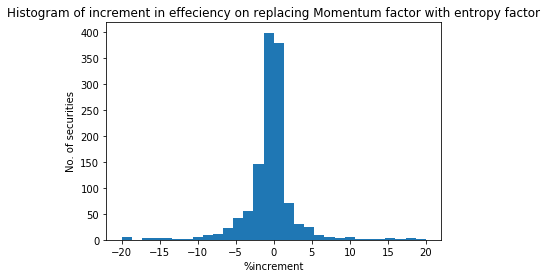

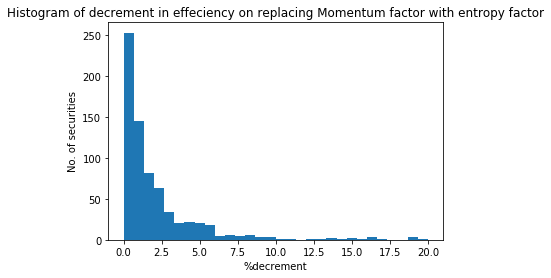

28

In [94]:
x=pd.DataFrame((comb["Adj-r_sq-Ent"]-comb["Adj-r_sq-wml"])*100/comb["Adj-r_sq-wml"],columns=["increment"])
std = x["increment"].std()
#x = x[(x["increment"])<2*std]
# the histogram of the data
n, bins, patches = plt.hist(x["increment"],30,range=(-20,20))
plt.xlabel('%increment')
plt.ylabel('No. of securities')
plt.title('Histogram of increment in effeciency on replacing Momentum factor with entropy factor')
plt.show()
y=x[(x["increment"]<0)]
n, bins, patches = plt.hist(-y["increment"],30,range=(0,20))
plt.xlabel('%decrement')
plt.ylabel('No. of securities')
plt.title('Histogram of decrement in effeciency on replacing Momentum factor with entropy factor')
plt.show()
len(y[(y["increment"]<-10)])

In [48]:
ent

,Symbol,Rm-Rf %,SMB %,HML %,high-low,Adj-r_sq,const
0,RIIL,0.0000,0.0000,0.0000,0.0056,0.4393,0.9497
1,WILLAMAGOR,0.0000,0.0000,0.0088,0.6129,0.1192,0.2548
2,UTTAMSTL,0.0000,0.0000,0.0000,0.0027,0.2505,0.3189
3,ENERGYDEV,0.0022,0.0000,0.0003,0.8994,0.0712,0.5816
4,CIMMCO,0.0000,0.0000,0.0022,0.1608,0.1166,0.3052
5,AXISBANK,0.0000,0.0378,0.9115,0.8928,0.1762,0.9673
6,IVP,0.0000,0.0000,0.0059,0.1780,0.1053,0.1306
7,HERITGFOOD,0.0000,0.0004,0.0353,0.6811,0.0872,0.3285
8,AEGISCHEM,0.0000,0.0000,0.0050,0.6663,0.0956,0.1596
9,BAJAJCORP,0.0000,0.0101,0.2396,0.3076,0.1036,0.2034
